In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy.linalg import circulant
from scipy.stats import norm
import seaborn as sns
import pandas as pd
from scipy.integrate import solve_ivp

def BinaryRandomMatrix(S,M,p):
    r = np.random.rand(S,M)
    m = np.zeros((S,M))
    m[r<p] = 1.0
    return m

def MakeAffinities(params):
    sampling = params['sampling']
    if sampling == 'Binary':
        pix = BinaryRandomMatrix(params['Num_tcell'],params['Num_sites'],params['pval_cell']) 
        palphax = (params['c'] + np.random.normal(0,params['sigma_cp'],(params['Num_treg'],params['Num_sites']) ) )* BinaryRandomMatrix(params['Num_treg'],params['Num_sites'],params['pval_treg']) 
    elif sampling == '1D':
        circ = circulant(norm.pdf(np.linspace(-params['Num_sites']/2,params['Num_sites']/2,params['Num_sites'])/params['niche_width'])/norm.pdf(0))
        Tcell_choice = np.random.choice(params['Num_sites'],size=params['Num_tcell'],replace=True)
        Treg_choice = np.random.choice(params['Num_sites'],size=params['Num_treg'],replace=True)
        pix = circ[Tcell_choice,:]
        palphax = params['c']*circ[Treg_choice,:]
    elif sampling == 'Circulant':
        circ = circulant(norm.pdf(np.linspace(-params['Num_sites']/2,params['Num_sites']/2,params['Num_sites'])/params['niche_width']))
        pix = circ[np.linspace(0,params['Num_sites']-1,params['Num_tcell'],dtype=int),:]
        palphax = params['c']*circ[np.linspace(0,params['Num_sites']-1,params['Num_treg'],dtype=int),:]
    elif sampling == 'Fixed_degree':
        pix = BinaryRandomMatrix(params['Num_tcell'],params['Num_sites'],params['pval_cell']) 
        palphax = np.zeros((params['Num_treg'],params['Num_sites']))
        degree = np.asarray(params['degree']+np.random.randn(params['Num_sites'])*params['sigma_degree'],dtype=int)
        for i in range(params['Num_sites']):
            palphax[:degree[i],i] = params['c']*np.ones(degree[i])+np.random.randn(degree[i])*params['sigma_c']
            np.random.shuffle(palphax[:,i])
    else:
        print('Invalid sampling choice. Valid choices are Binary, 1D, Circulant or Fixed_degree.')
        pix = np.nan
        palphax = np.nan
    return pix, palphax

def MakeOverlaps(pix,palphax,vx):
    phi_reg_reg = (palphax*vx).dot(palphax.T)
    phi_cell_reg = (pix*vx).dot(palphax.T)
    rvals = pix.dot(vx)
    return phi_reg_reg, phi_cell_reg, rvals

def TrainNetwork(phi_reg_reg,phi_cell_reg,rvals):
    Num_treg = len(phi_reg_reg)
    Num_tcell = len(phi_cell_reg)
    Treg = cvx.Variable(Num_treg)
    G = np.vstack((-(phi_cell_reg.T/rvals).T,-np.eye(Num_treg)))
    h = np.hstack((-np.ones(Num_tcell),np.zeros(Num_treg)))
    constraints = [G@Treg <= h]
    obj = cvx.Minimize((1/2)*cvx.quad_form(Treg,phi_reg_reg))
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver=cvx.ECOS,abstol=1e-7,feastol=1e-7,abstol_inacc=1e-7,feastol_inacc=1e-7,max_iters=100,verbose=False)
    Tcell=constraints[0].dual_value[:Num_tcell]/rvals
    Treg=Treg.value
    return Tcell,Treg

def ddt_simple(t,y,phi_reg_reg,phi_cell_reg,rvals):
    Num_treg = len(phi_reg_reg)
    Num_tcell = len(phi_cell_reg)
    Tcell = y[:Num_tcell]
    Treg = y[Num_tcell:]
    
    dTcelldt = Tcell*(rvals-phi_cell_reg.dot(Treg))
    dTregdt = Treg*(phi_cell_reg.T.dot(Tcell) - phi_reg_reg.dot(Treg))
    
    return np.hstack((dTcelldt, dTregdt))

# Full model

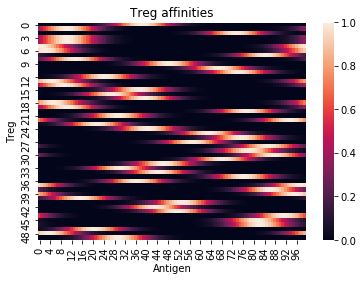

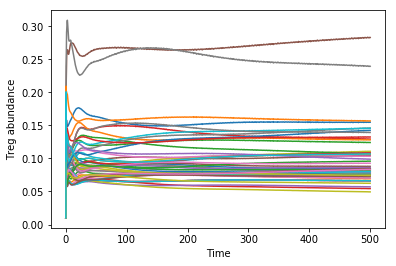

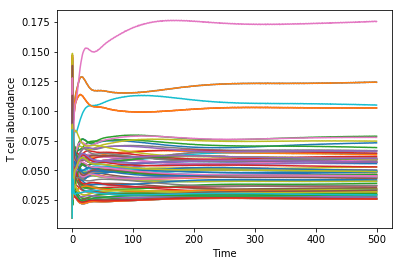

In [156]:
# Parameters
t0 = 0
tf = 500
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 50
params['Num_tcell'] = 100
params['Num_sites'] = 100
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/params['Num_treg']
y0 = np.ones(params['Num_treg']+params['Num_tcell'])*0.01

# Make affinities and plot
pix, palphax = MakeAffinities(params)
sns.heatmap(palphax)
plt.gca().set_title('Treg affinities')
plt.gca().set_xlabel('Antigen')
plt.gca().set_ylabel('Treg')
plt.show()

#Make antigen concentrations
vx = (params['max_v']/2)*np.ones(params['Num_sites'])

#Make overlaps and train
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)

out = solve_ivp(lambda t,y: ddt_simple(t,y,phi_reg_reg,phi_cell_reg,rvals),(t0,tf),y0)

Tcell = out.y[:params['Num_tcell'],:].T
Treg = out.y[params['Num_tcell']:,:].T
t = out.t

fig,ax=plt.subplots()
ax.plot(t,Treg)
ax.set_xlabel('Time')
ax.set_ylabel('Treg abundance')
plt.show()

fig,ax=plt.subplots()
ax.plot(t,Tcell)
ax.set_xlabel('Time')
ax.set_ylabel('T cell abundance')
plt.show()

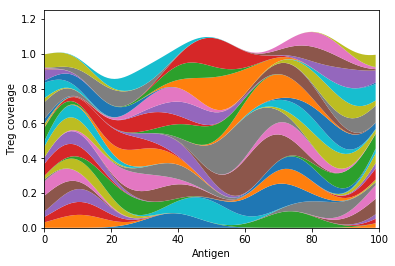

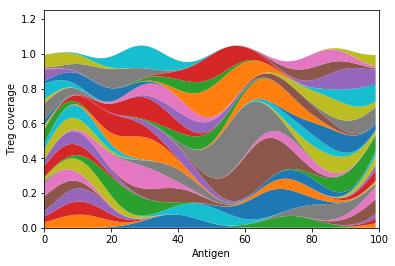

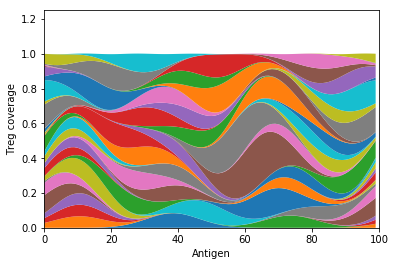

In [158]:
#Plot Treg coverage
times = [8,18,-1]
for time in times:
    coverage = palphax.T*Treg[time]
    fig,ax = plt.subplots()
    ax.stackplot(np.arange(len(vx)),coverage.T)
    ax.plot([Num_path,Num_path],[0,1.25],'k--')
    ax.set_ylim((0,1.25))
    ax.set_xlim((0,len(vx)))
    ax.set_xlabel('Antigen')
    ax.set_ylabel('Treg coverage')
    plt.show()

# Phase transition

[Landmann and Engel (2018)](https://iopscience.iop.org/article/10.1209/0295-5075/124/18004/pdf) report criteria for the existence of positive solutions $\mathbf{x}$ ($x_i\geq 0$ for all $i$) to a linear system of equations

\begin{align}
A \mathbf{x} = \mathbf{R}
\end{align}

where $A$ is an i.i.d. random matrix of dimension $N \times M$ and the elements of $\mathbf{R}$ are $R_i = 1 + \delta R_i$, where $\delta R_i$ is a Gaussian random variable with mean 0 and variance $r^2/N$. They find a sharp transition in the probability of a solution existing, as a function of the ratio $\alpha = M/N$ and the noise $r^2$. When $r^2 = 0$, the transition takes place at $\alpha_c = 2$. 

We now see that the problem of eliminating sensitivity to $v_x$ takes precisely this form. Setting $\partial g_i/\partial v_x = 0$ gives

\begin{align}
\sum_\alpha p_{\alpha x} \frac{w_\alpha}{\rho} = 1.
\end{align}

When $p_{\alpha x}$ is binary, this is precisely the problem studied by Landmann and Engel, and should have the same phase transition.

It seems to work, with the precision of the shielded phase determined by the number of T cells.

## Binary, i.i.d.

0.1
0.2
0.3


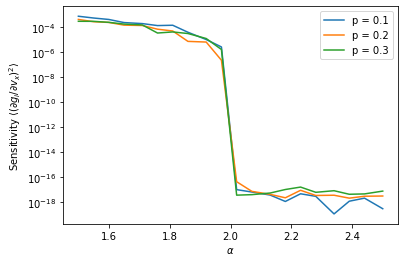

In [5]:
#declare simulation paramaters:
M_vec = np.linspace(150,250,20,dtype=int)
pvec = [0.1,0.2,0.3]
Num_rep = 30
thresh=1e-3
params={
'sampling' : 'Binary',
#the number of Tregs
'Num_treg' : 10000,
#the number of Tcells
'Num_tcell' : 1000,
#the number of sites
'Num_sites' : 100,
#the Treg- antigen site binding strenth
'c' : 1.0,
#the varience in Treg-antigen binding around zero
'sigma_c' : 0.2,
#the varience in Treg-antigen binding around c
'sigma_cp' : 0.0,
#the binding
'pval_cell' : 0.1,
'pval_treg' : 0.1,
'max_v' : 1.0}
alpha_vec = M_vec/params['Num_sites']

#Define antigen concentrations
vx = 0.5*params['max_v'] * np.ones(params['Num_sites']) 

sensitivity_all = pd.DataFrame(index=alpha_vec,columns=pvec)
for p in pvec:
    print(p)
    params['pval_cell'] = p
    params['pval_treg'] = p
    pix, palphax = MakeAffinities(params)
    phi_reg_reg_base, phi_cell_reg_base, rvals = MakeOverlaps(pix,palphax,vx)
    sensitivity = np.zeros(len(M_vec))
    for k in range(len(M_vec)):
        M = M_vec[k]
        sense_temp = []
    
        for j in range(Num_rep):
            Treg_list = np.random.choice(params['Num_treg'],size=M,replace=False)
            phi_reg_reg = phi_reg_reg_base[Treg_list,:]
            phi_reg_reg = phi_reg_reg[:,Treg_list]
            phi_cell_reg = phi_cell_reg_base[:,Treg_list]
            Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)
            dgdvx = ((pix*(1-palphax[Treg_list,:].T.dot(Treg)))**2).mean()
            sense_temp.append(dgdvx)
            
        sensitivity[k] = np.median(sense_temp)
    sensitivity_all[p] = sensitivity

    plt.semilogy(alpha_vec,sensitivity,label='p = '+str(p))
sensitivity_all.to_csv('../data/sensitivity_binary.csv')
plt.legend()
plt.gca().set_xlabel(r'$\alpha$')
plt.gca().set_ylabel(r'Sensitivity $\langle (\partial g_i/\partial v_x)^2\rangle$')
plt.show()

## 1D niche axis

Can also try with the Gaussian matrices. My conjecture is that $\alpha$ corresponds to the inverse fraction of nonzero eigenvalues. It's a crossover, though, with approximately exponential decay.

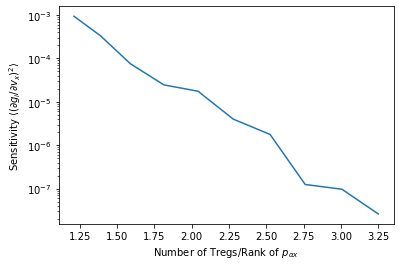

In [13]:
#declare simulation paramaters:
nw_vec = np.linspace(1,4,10)
Num_rep = 10
thresh=1e-4
params={
'sampling' : '1D',
#the number of Tregs
'Num_treg' : 500,
#the number of Tcells
'Num_tcell' : 500,
#the number of sites
'Num_sites' : 5000,
#the Treg- antigen site binding strenth
'c' : 1.0,
#the varience in Treg-antigen binding around zero
'sigma_c' : 0.0,
#the varience in Treg-antigen binding around c
'sigma_cp' : 0.0,
#the binding
'pval_cell' : 0.1,
'pval_treg' : 0.1,
'max_v' : 1.0}

#generate a Treg-Tcell graph
#######################################


#Define antigen concentrations
vx = 0.5*params['max_v'] * np.ones(params['Num_sites']) 

####################################################################################
#compute the Treg steady state and active set of constraints
sensitivity = np.zeros(len(nw_vec))
alpha_vec = np.zeros(len(nw_vec))

for k in range(len(nw_vec)):
    params['niche_width'] = nw_vec[k]*params['Num_sites']/params['Num_treg']
    sense_temp = []
    
    for j in range(Num_rep):
        pix, palphax = MakeAffinities_circulant_rand(params)
        phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
        Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)
        dgdvx = ((pix*(1-palphax.T.dot(Treg)))**2).mean()
        lam,u = np.linalg.eig(phi_reg_reg)
        alpha_vec[k] += params['Num_treg']/((lam>thresh).sum()*Num_rep)
        sense_temp.append(dgdvx)
            
    sensitivity[k] = np.median(sense_temp)
    
plt.semilogy(alpha_vec,sensitivity)
plt.gca().set_xlabel(r'Number of Tregs/Rank of $p_{\alpha x}$')
plt.gca().set_ylabel(r'Sensitivity $\langle (\partial g_i/\partial v_x)^2\rangle$')
plt.show()

# Pathogen response, allergies, persistent infection

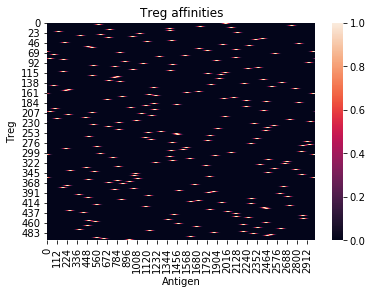

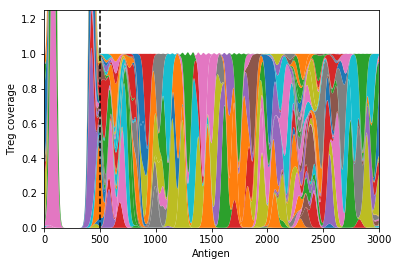

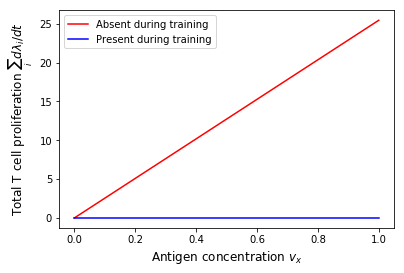

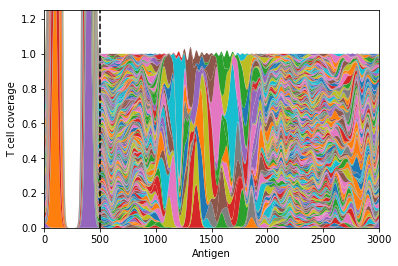

----------------Train to persistent infection--------------------


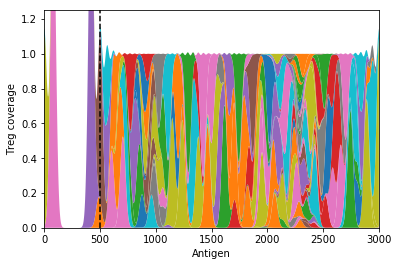

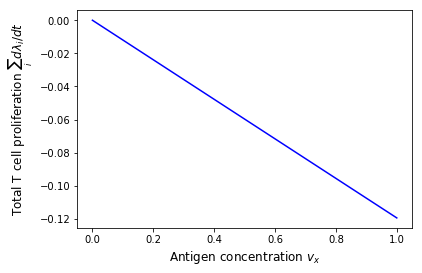

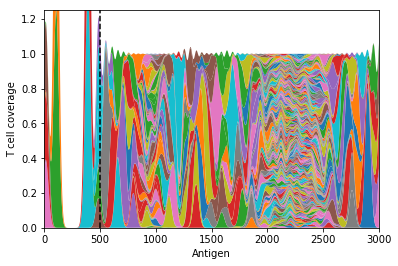

In [126]:
# Parameters
Num_path = 500
reg_thresh = 1e-2
cell_thresh = 1e-4
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 500
params['Num_tcell'] = 5000
params['Num_sites'] = 3000
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/params['Num_treg']

# Make affinities and plot
pix, palphax = MakeAffinities(params)
sns.heatmap(palphax)
plt.gca().set_title('Treg affinities')
plt.gca().set_xlabel('Antigen')
plt.gca().set_ylabel('Treg')
plt.show()

#Make antigen concentrations
vx = (params['max_v']/2)*np.ones(params['Num_sites'])
vx[:Num_path] = 0

#Positive selection:
palphax = palphax[palphax.dot(vx)>reg_thresh]
pix = pix[pix.dot(vx)>cell_thresh]

#Make overlaps and train
#palphax = palphax*(1+np.random.randn(params['Num_treg'],params['Num_sites'])*0.01)
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('Treg coverage')
plt.show()

#Plot response for two antigens
colorlist = np.asarray(['b','r'])
colors = colorlist[np.asarray(vx==0,dtype=int)]
dTcellxdt = ((pix*(1-palphax.T.dot(Treg))).T*Tcell).sum(axis=1)
vx_axis = np.linspace(0,1,5)
xmin = np.argmax(dTcellxdt)
xnormal = 510
fig,ax = plt.subplots()
for x in [xmin,xnormal]:
    ax.plot(vx_axis,dTcellxdt[x]*vx_axis,color=colors[x])
ax.plot([0],[0],color=colorlist[1],label='Absent during training')
ax.plot([0],[0],color=colorlist[0],label='Present during training')
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
#ax.set_ylim((-1,1))
plt.legend()
plt.show()

#Zoom in
#Plot response for two antigens
fig,ax = plt.subplots()
ax.plot(vx_axis,dTcellxdt[xnormal]*vx_axis,color=colors[xnormal])
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
plt.legend()
plt.show()

#Plot T cell coverage
coverage = pix.T*Tcell
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('T cell coverage')
plt.show()

print('----------------Train to persistent infection--------------------')

#Re-train with all antigens present
vx = (params['max_v']/2)*np.ones(params['Num_sites'])
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('Treg coverage')
plt.show()

#Plot response for self antigen
dTcellxdt = ((pix*(1-palphax.T.dot(Treg))).T*Tcell).sum(axis=1)
xmin = np.argmax(dTcellxdt[Num_path:])+Num_path
vx_axis = np.linspace(0,1,5)
fig,ax = plt.subplots()
ax.plot(vx_axis,dTcellxdt[xmin]*vx_axis,color=colors[xnormal])
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
#ax.set_ylim((-1,1))
plt.show()

#Plot T cell coverage
coverage = pix.T*Tcell
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('T cell coverage')
plt.show()

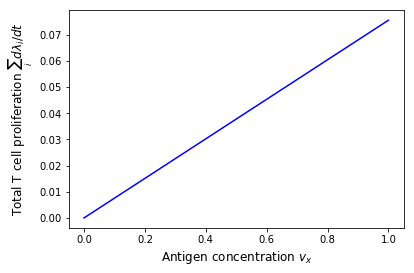

In [130]:
#Plot response for self antigen
dTcellxdt = ((pix*(1-palphax.T.dot(Treg))).T*Tcell).sum(axis=1)
xmin = np.argmax(dTcellxdt[Num_path:])+Num_path
vx_axis = np.linspace(0,1,5)
fig,ax = plt.subplots()
ax.plot(vx_axis,dTcellxdt[xmin]*vx_axis,color=colors[xnormal])
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
#ax.set_ylim((-1,1))
plt.show()

# T cell population bottleneck

An important series of early experiments [[1](https://rupress.org/jem/article/161/1/72/23401/Organ-specific-autoimmune-diseases-induced-in-mice)][[2](https://www.jimmunol.org/content/155/3/1151.short?casa_token=pkZx4xri-xUAAAAA:1XWyrT9mnDT307ATOLV73Y596eKB4Ck64IXG3aH_AvEXrbLEktdrxW74bl4lNG-MN2mrXz3yBlZs)] in the study of Tregs looked at the consequences of putting T cells from one mouse into another that congenitally lacks T cells (so called "athymic nude" mice). These are nice studies for our purposes, because they do not involve any manipulation of the antigens or of the process of T cell production. They are purely external interventions, that we can really hope to explain.

To a first approximation, the experiments work as follows. In the first treatment, the athymic mice receive an unbiased sample of the T cells from the donor. In the second, the donor cells are pre-treated with antibodies and complement to kill off the Tregs. There is no single obvious cell surface marker that is specific only for Tregs, so the experiments differ in which markers they use to target putative T cells for destruction. After a few months, the two groups of mice are examined for symptoms of autoimmune disorders. The first study shows photographs of various organs of the two groups, while the second reports concentrations of anitbodies against various self proteins. The mice in the second group always get severe autoimmune attacks, while the first group is fine.

This experiment on its own is not a real test of our theory, because it just says that Tregs are important for suppressing autoimmunity. Since _all_ the Tregs are removed, we don't really learn anything beyond this. But now that people know how to clonally expand Tregs in vitro, one can imagine a slightly more sophisticated experiment. Instead of putting in buckets of antibody-plus-complement to kill _all_ the Tregs, you make several groups with different levels of antibody, leaving different (small) populations of Tregs behind. By killing most, but not all, of the Tregs, you impose a strong population bottleneck, and reduce the receptor diversity. Now you use the clonal expansion protocols to boost the absolute number of Tregs back up to the original level. (The diversity of Tregs can actually be measured now with sequencing, so you can check how much diversity is actually left). (Even if none of the Treg clones actually go extinct, the clonal expansion protocol (which I haven't studied yet) is likely to cause the Treg populations to drift away from the perfect tiling point.)

Now we can plot concentrations of self-antibodies as a function of Treg diversity. And we should see something like Figure 3b.